<a href="https://colab.research.google.com/github/YaroslavSnarski/NLP-Hackathon-Project/blob/main/Final_Embeddings_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summer School's Hackathon Project "Academy vs. Media".
The goal of the project is to investigate the lexical differences in two corpora, academic and media texts in English.

RQ: How much different are the same words in academic and media context? To answer the RQ, I train two <word2vec> models.

To solve the task, I propose the following pipeline:
-


In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import urllib.request
import shutil
import os
import random
from copy import deepcopy

# Загрузка данных медиа

In [ ]:
import json
import pandas as pd

with open('/content/drive/MyDrive/Embeddings_mediascience/en_texts_terms_media.jsonl', 'r',
          encoding = 'utf-8') as json_file:
    json_list = list(json_file)

en_texts_terms_media = []

for json_str in json_list:
    result = json.loads(json_str)
    en_texts_terms_media.append(result)

df_en_texts_terms_media = pd.DataFrame(en_texts_terms_media)
df_en_texts_terms_media.head(10)

,text,title,year,authors,terms
0,This week's Barron's interview was with long-t...,Oil at $300 and Dow 37K by 2020?,2011-02-14,[Bespoke Investment Group],"{'title': {'NP': [{'count': 1, 'term': 'oil'},..."
1,Muni issuers' exposure to the battle against C...,Could U.S. Municipals Suffer As Coronavirus Sp...,2020-03-23,"[Alliancebernstein, Ab]","{'title': {'NP': [{'count': 1, 'term': 'u.s._m..."
2,Whether you are new to dividend investing or y...,Building A 6% Income Portfolio For 2013 (Part ...,2012-12-26,[Parsimony Investment Research],"{'title': {'NP': [{'count': 1, 'term': '6_inco..."
3,Have a view on something that’s coming up or a...,ETF Update: ETF Issuers Do Not Slow Down In De...,2015-12-27,[Sa Editor Carolyn Pairitz Morris],"{'title': {'NP': [{'count': 1, 'term': 'etf_is..."
4,There are two broad themes among the major cur...,"Greenback Recovers, But Antipodeans Advance",2015-12-10,"[Marc Chandler, Marc To Market]","{'title': {'NP': [{'count': 1, 'term': 'greenb..."
5,By David BermanKeep an eye on the 10-year Trea...,Pain Threshold Nears With Bond Yield,2011-02-07,[Market Blog],"{'title': {'NP': [{'count': 1, 'term': 'bond_y..."
6,The debut of Walt Disney Co.’s ( DIS ) “Avenge...,Disney: 'Infinity War' Draws $200M in China Debut,2018-05-14,[Rebecca McClay],"{'article_body': {'NP': [{'count': 1, 'term': ..."
7,The Relative Strength (RS) Rating for Comerica...,Comerica Getting Closer To Key Technical Measure,2017-09-20,[INVESTOR'S BUSINESS DAILY],"{'article_body': {'NP': [{'count': 1, 'term': ..."
8,Below is the incredible New York Times editori...,Oops: The New York Times Accidentally Exposed ...,2017-05-12,[JOHN MERLINE],"{'article_body': {'NP': [{'count': 1, 'term': ..."
9,The Export-Import Bank of the United States (U...,US Exim funds Australian LNG,2013-01-03,"[G, T, R]","{'article_body': {'NP': [{'count': 2, 'term': ..."


# Токенизация и векторизация с помощью регулярных выражений

In [ ]:
# очистим данные от лишних символов
import re

df_en_texts_terms_media['lines'] = [[i] for i in df_en_texts_terms_media['text']]

df_en_texts_terms_media['lines_processed'] = df_en_texts_terms_media['lines'].apply(lambda x: re.sub(r'\s+', ' ', ' '.join(x)))
df_en_texts_terms_media['lines_processed'] = df_en_texts_terms_media['lines_processed'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
df_en_texts_terms_media['lines_processed'] = df_en_texts_terms_media['lines_processed'].apply(lambda x: re.sub(r'summary', '', x.lower()))
df_en_texts_terms_media['lines_processed'] = df_en_texts_terms_media['lines_processed'].apply(lambda x: x.strip())
df_en_texts_terms_media.tail()

,text,title,year,authors,terms,lines,lines_processed
4995,SummaryCredit markets are overstating WU’s fun...,Cash Pays Off For Western Union (NYSE:WU),2015-04-17,[Valens Research],"{'title': {'NP': [{'count': 1, 'term': 'cash'}...",[SummaryCredit markets are overstating WU’s fu...,credit markets are overstating wus fundamental...
4996,SummaryCalamos Asset Management went public at...,Calamos Asset Management: IPO At $18.00 To Go ...,2016-12-20,[Pat Stout],"{'title': {'NP': [{'count': 1, 'term': 'ipo'},...",[SummaryCalamos Asset Management went public a...,calamos asset management went public at 1800 o...
4997,"SummaryIn this series of articles, I will be r...",Alaska Air Group: My Top Airline Stock For 201...,2016-12-21,[Stan Stafford],"{'title': {'NP': [{'count': 1, 'term': 'top_ai...","[SummaryIn this series of articles, I will be ...",in this series of articles i will be reviewing...
4998,SummaryMRO is increasing production from asset...,Why Marathon Oil's Bull Run Will Continue In 2...,2016-12-25,[Alpha Investor],"{'title': {'NP': [{'count': 1, 'term': 'marath...",[SummaryMRO is increasing production from asse...,mro is increasing production from assets where...
4999,"In recent reports, we've discussed the lack of...",Will Global Growth Worries Boost Gold Demand?,2018-11-16,[Clif Droke],"{'title': {'NP': [{'count': 1, 'term': 'global...","[In recent reports, we've discussed the lack o...",in recent reports weve discussed the lack of s...


In [ ]:
df_en_texts_terms_media.head(10)

,text,title,year,authors,terms,lines,lines_processed,text_lemmatized
0,This week's Barron's interview was with long-t...,Oil at $300 and Dow 37K by 2020?,2011-02-14,[Bespoke Investment Group],"{'title': {'NP': [{'count': 1, 'term': 'oil'},...",[This week's Barron's interview was with long-...,this weeks barrons interview was with longtime...,week barron interview longtime energy analyst ...
1,Muni issuers' exposure to the battle against C...,Could U.S. Municipals Suffer As Coronavirus Sp...,2020-03-23,"[Alliancebernstein, Ab]","{'title': {'NP': [{'count': 1, 'term': 'u.s._m...",[Muni issuers' exposure to the battle against ...,muni issuers exposure to the battle against co...,muni issuer exposure battle covid19 vary secto...
2,Whether you are new to dividend investing or y...,Building A 6% Income Portfolio For 2013 (Part ...,2012-12-26,[Parsimony Investment Research],"{'title': {'NP': [{'count': 1, 'term': '6_inco...",[Whether you are new to dividend investing or ...,whether you are new to dividend investing or y...,new dividend investing seasoned pro likely mai...
3,Have a view on something that’s coming up or a...,ETF Update: ETF Issuers Do Not Slow Down In De...,2015-12-27,[Sa Editor Carolyn Pairitz Morris],"{'title': {'NP': [{'count': 1, 'term': 'etf_is...",[Have a view on something that’s coming up or ...,have a view on something thats coming up or a ...,view s come new fund submit articleevery week ...
4,There are two broad themes among the major cur...,"Greenback Recovers, But Antipodeans Advance",2015-12-10,"[Marc Chandler, Marc To Market]","{'title': {'NP': [{'count': 1, 'term': 'greenb...",[There are two broad themes among the major cu...,there are two broad themes among the major cur...,broad theme major currency today pullback euro...
5,By David BermanKeep an eye on the 10-year Trea...,Pain Threshold Nears With Bond Yield,2011-02-07,[Market Blog],"{'title': {'NP': [{'count': 1, 'term': 'bond_y...",[By David BermanKeep an eye on the 10-year Tre...,by david bermankeep an eye on the 10year treas...,david bermankeep eye 10year treasury bond yiel...
6,The debut of Walt Disney Co.’s ( DIS ) “Avenge...,Disney: 'Infinity War' Draws $200M in China Debut,2018-05-14,[Rebecca McClay],"{'article_body': {'NP': [{'count': 1, 'term': ...",[The debut of Walt Disney Co.’s ( DIS ) “Aveng...,the debut of walt disney cos dis avengers in...,debut walt disney cos dis avenger infinity war...
7,The Relative Strength (RS) Rating for Comerica...,Comerica Getting Closer To Key Technical Measure,2017-09-20,[INVESTOR'S BUSINESS DAILY],"{'article_body': {'NP': [{'count': 1, 'term': ...",[The Relative Strength (RS) Rating for Comeric...,the relative strength rs rating for comerica ...,relative strength rs rating comerica cma head ...
8,Below is the incredible New York Times editori...,Oops: The New York Times Accidentally Exposed ...,2017-05-12,[JOHN MERLINE],"{'article_body': {'NP': [{'count': 1, 'term': ...",[Below is the incredible New York Times editor...,below is the incredible new york times editori...,incredible new york times editorial publish th...
9,The Export-Import Bank of the United States (U...,US Exim funds Australian LNG,2013-01-03,"[G, T, R]","{'article_body': {'NP': [{'count': 2, 'term': ...",[The Export-Import Bank of the United States (...,the exportimport bank of the united states us ...,exportimport bank united states exim provide u...


# Токенизация с помощью SpaCy

In [ ]:
import spacy
lemma = spacy.load("en_core_web_sm")
from spacy.lang.en import stop_words
from sklearn.preprocessing import LabelEncoder

def process(text: str, lemma:spacy): #функция для предобработки
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = lemma(text)
    text = ' '.join([token.lemma_ for token in text])
    text = ' '.join([word for word in text.split() if word not in stop_words.STOP_WORDS])
    return text

df_en_texts_terms_media['text_lemmatized'] = df_en_texts_terms_media['text'].apply(lambda x: process(x, lemma))

In [ ]:
df_en_texts_terms_media[0:10]

,text,title,year,authors,terms,lines,lines_processed,text_lemmatized
0,This week's Barron's interview was with long-t...,Oil at $300 and Dow 37K by 2020?,2011-02-14,[Bespoke Investment Group],"{'title': {'NP': [{'count': 1, 'term': 'oil'},...",[This week's Barron's interview was with long-...,this weeks barrons interview was with longtime...,week barron interview longtime energy analyst ...
1,Muni issuers' exposure to the battle against C...,Could U.S. Municipals Suffer As Coronavirus Sp...,2020-03-23,"[Alliancebernstein, Ab]","{'title': {'NP': [{'count': 1, 'term': 'u.s._m...",[Muni issuers' exposure to the battle against ...,muni issuers exposure to the battle against co...,muni issuer exposure battle covid19 vary secto...
2,Whether you are new to dividend investing or y...,Building A 6% Income Portfolio For 2013 (Part ...,2012-12-26,[Parsimony Investment Research],"{'title': {'NP': [{'count': 1, 'term': '6_inco...",[Whether you are new to dividend investing or ...,whether you are new to dividend investing or y...,new dividend investing seasoned pro likely mai...
3,Have a view on something that’s coming up or a...,ETF Update: ETF Issuers Do Not Slow Down In De...,2015-12-27,[Sa Editor Carolyn Pairitz Morris],"{'title': {'NP': [{'count': 1, 'term': 'etf_is...",[Have a view on something that’s coming up or ...,have a view on something thats coming up or a ...,view s come new fund submit articleevery week ...
4,There are two broad themes among the major cur...,"Greenback Recovers, But Antipodeans Advance",2015-12-10,"[Marc Chandler, Marc To Market]","{'title': {'NP': [{'count': 1, 'term': 'greenb...",[There are two broad themes among the major cu...,there are two broad themes among the major cur...,broad theme major currency today pullback euro...
5,By David BermanKeep an eye on the 10-year Trea...,Pain Threshold Nears With Bond Yield,2011-02-07,[Market Blog],"{'title': {'NP': [{'count': 1, 'term': 'bond_y...",[By David BermanKeep an eye on the 10-year Tre...,by david bermankeep an eye on the 10year treas...,david bermankeep eye 10year treasury bond yiel...
6,The debut of Walt Disney Co.’s ( DIS ) “Avenge...,Disney: 'Infinity War' Draws $200M in China Debut,2018-05-14,[Rebecca McClay],"{'article_body': {'NP': [{'count': 1, 'term': ...",[The debut of Walt Disney Co.’s ( DIS ) “Aveng...,the debut of walt disney cos dis avengers in...,debut walt disney cos dis avenger infinity war...
7,The Relative Strength (RS) Rating for Comerica...,Comerica Getting Closer To Key Technical Measure,2017-09-20,[INVESTOR'S BUSINESS DAILY],"{'article_body': {'NP': [{'count': 1, 'term': ...",[The Relative Strength (RS) Rating for Comeric...,the relative strength rs rating for comerica ...,relative strength rs rating comerica cma head ...
8,Below is the incredible New York Times editori...,Oops: The New York Times Accidentally Exposed ...,2017-05-12,[JOHN MERLINE],"{'article_body': {'NP': [{'count': 1, 'term': ...",[Below is the incredible New York Times editor...,below is the incredible new york times editori...,incredible new york times editorial publish th...
9,The Export-Import Bank of the United States (U...,US Exim funds Australian LNG,2013-01-03,"[G, T, R]","{'article_body': {'NP': [{'count': 2, 'term': ...",[The Export-Import Bank of the United States (...,the exportimport bank of the united states us ...,exportimport bank united states exim provide u...


In [ ]:
df_en_texts_terms_media['text'][0:2].apply(lambda x: process(x, lemma))

0    week barron interview longtime energy analyst ...
1    muni issuer exposure battle covid19 vary secto...
Name: text, dtype: object

# Сохраняем в txt файлы

In [ ]:
mediacorpus_processed = ' \n'.join([i for i in df_en_texts_terms_media['lines_processed']])
f = open("mediacorpus_processed.txt", "w")
f.write(mediacorpus_processed)
f.close()

In [ ]:
mediacorpus_lemmatized = ' \n'.join([i for i in df_en_texts_terms_media['text_lemmatized']])
f = open("mediacorpus_lemmatized.txt", "w")
f.write(mediacorpus_lemmatized)
f.close()


In [ ]:
def stream_data(local_file):
  """ Read the data from the web and convert into a corpus
  that gensim can consume.

  Parameters:
  ===========
  link_to_file (str): link to the data
  local_file (str): local filename

  Returns:
  ========
  corpus (LineSentence): gensim object that segments the text into sentences
  """

  # Expected to return a list of lists or an iterable of that kind
  # (maybe try gensim's LineSentence)
#  if not os.path.exists (local_file):
#    with urllib.request.urlopen(link_to_file) as response, open(local_file, 'wb', encoding = 'utf-8') as out_file:
#      shutil.copyfileobj(response, out_file)

  corpus = LineSentence(local_file)
  return corpus

In [ ]:
local_file = 'mediacorpus_lemmatized.txt'
media_corpus = stream_data(local_file=local_file)

In [ ]:
media_model = Word2Vec(media_corpus, window=10, min_count=10, seed=42, workers=1)
media_model

In [ ]:
sims = media_model.wv.most_similar('science', topn=10)  # get other similar words
for item in sims:
  print (item)

('advertising', 0.8942601084709167)
('computer', 0.8904563784599304)
('youtube', 0.8896752595901489)
('tablet', 0.8778342008590698)
('sport', 0.8698909878730774)
('connectivity', 0.8679893612861633)
('automation', 0.86652672290802)
('communication', 0.8639265894889832)
('media', 0.8627964854240417)
('content', 0.8618840575218201)


In [ ]:
def w2v_to_numpy (model):
  """ Convert the word2vec model (the embeddings) into numpy arrays.
  Also create and return the mapping of words to the row numbers.

  Parameters:
  ===========
  model (gensim.Word2Vec): a trained gensim model

  Returns:
  ========
  embeddings (numpy.ndarray): Embeddings of each word
  idx, iidx (tuple): idx is a dictionary mapping word to row number
                     iidx is a dictionary mapping row number to word
  """
  model.wv.fill_norms()
  embeddings = deepcopy (model.wv.get_normed_vectors())
  idx = {w:i for i, w in enumerate (model.wv.index_to_key)}
  iidx = {i:w for i, w in enumerate (model.wv.index_to_key)}
  return embeddings, (idx, iidx)

In [ ]:
media_embs, (media_idx, media_iidx) = w2v_to_numpy (media_model)

# Загрузка данных наука

In [ ]:
import json
import pandas as pd

with open('/content/drive/MyDrive/Embeddings_mediascience/en_texts_terms_science.jsonl', 'r',
          encoding = 'utf-8') as json_file:
    json_list = list(json_file)

en_texts_terms_science = []

for json_str in json_list:
    result = json.loads(json_str)
    en_texts_terms_science.append(result)

df_en_texts_terms_science = pd.DataFrame(en_texts_terms_science)
df_en_texts_terms_science.head(10)

,thematic,text,year,authors,terms
0,Electronic engineering,This paper gives an investigation into the use...,2016-09-01,"[Xiaoqing Zhan, Ruihong Zhang, Henry Shu-Hung ...","{'NP': [{'count': 1, 'term': 'paper'}, {'count..."
1,Mathematics,"In this paper, we provide a constructive metho...",2014-12-01,"[Pierdomenico Pepe, Hiroshi Ito, Zhong-Ping Ji...","{'NP': [{'count': 1, 'term': 'paper'}, {'count..."
2,Anchoring,Liquid crystal cells with hybrid boundary anch...,2013-11-06,"[M. Buczkowska, G. Derfel]","{'NP': [{'count': 1, 'term': 'liquid_crystal_c..."
3,Cysteine,Sortases are cell-membrane-anchored cysteine t...,2011-10-01,"[Ramakumar Suryanarayanarao, Rajendra P. Roy, ...","{'NP': [{'count': 1, 'term': 'sortase'}, {'cou..."
4,Internal medicine,We thank Drs. Naqvi and Gotway for their comme...,2015-07-28,"[Seth Uretsky, Steven D. Wolff]","{'NP': [{'count': 1, 'term': 'comment'}, {'cou..."
5,Market power,Improvement of products and production process...,2014-01-01,[Nevena S. Stanisavljeviæ],"{'NP': [{'count': 1, 'term': 'improvement'}, {..."
6,Management,The maritime industry is always open to buildi...,2011-01-01,[Helen Iakovaki],"{'NP': [{'count': 1, 'term': 'maritime_industr..."
7,Noise (electronics),We study stochastic model reduction for evolut...,2020-10-11,"[Sigurd Assing, Umberto Pappalettera, Franco F...","{'NP': [{'count': 1, 'term': 'stochastic_model..."
8,Design assessment,Composite materials offer lot of advantages in...,2019-09-22,"[Benjamin Collier, Pol Muller, Pierre Berthelo...","{'NP': [{'count': 2, 'term': 'composite_materi..."
9,Nearest neighbor search,The extreme volume and staggeringly increasing...,2015-10-29,"[Yixin Chen, Yu Hua, Nan Zhu, Wenbo He]","{'NP': [{'count': 1, 'term': 'extreme_volume'}..."


In [ ]:
df_en_texts_terms_science.tail(10)

,thematic,text,year,authors,terms
990,Politics,Abstract:Since the formation of human resource...,2016-11-01,[Ivana Hirschegger],"{'NP': [{'count': 1, 'term': 'formation'}, {'c..."
991,Ignition system,A CNG/diesel dual-fuel engine uses CNG as the ...,2011-04-01,"[최건호, 임옥택]","{'NP': [{'count': 2, 'term': 'cng_diesel_dual_..."
992,Water resources,"With the rapid development of social economy,t...",2014-01-01,[GU Zi-qian],"{'NP': [{'count': 1, 'term': 'rapid_developmen..."
993,Malignancy,AIM: To investigate the effect of stem cells f...,2014-01-01,"[Abbas, Ardeshir, Ali, Nosrat, Heidari, Behnia...","{'NP': [{'count': 1, 'term': 'effect'}, {'coun..."
994,Fiscal policy,"Using the method of optimal control, when an i...",2015-01-01,"[Ganesh Manjhi, Meeta Keswani Mehra]","{'NP': [{'count': 1, 'term': 'method'}, {'coun..."
995,Position (vector),The method of determining heat flow coming fro...,2013-01-01,"[K. I. Myhalenko, M. M. Semerak, A. М. Dominik...","{'NP': [{'count': 1, 'term': 'method'}, {'coun..."
996,Market niche,The development of minimarkets in Indonesia is...,2020-07-25,"[Diana Fajarwati, Rhian Indradewa, Meydi Nindi...","{'NP': [{'count': 1, 'term': 'development'}, {..."
997,Input selection,Packet based Network-on-Chip (NoC) connect ten...,2018-10-04,"[Sangeetha Jose, Abhijit Das, Sarath Babu, Mau...","{'NP': [{'count': 1, 'term': 'network'}, {'cou..."
998,Animal ecology,Abstract The colors of primates are among the ...,2019-01-01,"[Ismael Galván, Gustavo A. Gutiérrez-Espeleta,...","{'NP': [{'count': 1, 'term': 'abstract'}, {'co..."
999,Moment (mathematics),This study is focused on the verification of t...,2013-11-21,"[Donghoon Kang, Won-Seok Chung]","{'NP': [{'count': 2, 'term': 'study'}, {'count..."


# Токенизация с помощью регулярных выражений и SpaCy

In [ ]:
# очистим данные от лишних символов
import re
import pandas as pd
df_en_texts_terms_science = pd.DataFrame(en_texts_terms_science)
#df_en_texts_terms_media.head(10)

df_en_texts_terms_science['lines'] = [[i] for i in df_en_texts_terms_science['text']]

df_en_texts_terms_science['lines_processed'] = df_en_texts_terms_science['lines'].apply(lambda x: re.sub(r'\s+', ' ', ' '.join(x)))
df_en_texts_terms_science['lines_processed'] = df_en_texts_terms_science['lines_processed'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
df_en_texts_terms_science['lines_processed'] = df_en_texts_terms_science['lines_processed'].apply(lambda x: re.sub(r'abstract', '', x.lower()))
df_en_texts_terms_science['lines_processed'] = df_en_texts_terms_science['lines_processed'].apply(lambda x: x.strip())
df_en_texts_terms_science.tail()

,thematic,text,year,authors,terms,lines,lines_processed
995,Position (vector),The method of determining heat flow coming fro...,2013-01-01,"[K. I. Myhalenko, M. M. Semerak, A. М. Dominik...","{'NP': [{'count': 1, 'term': 'method'}, {'coun...",[The method of determining heat flow coming fr...,the method of determining heat flow coming fro...
996,Market niche,The development of minimarkets in Indonesia is...,2020-07-25,"[Diana Fajarwati, Rhian Indradewa, Meydi Nindi...","{'NP': [{'count': 1, 'term': 'development'}, {...",[The development of minimarkets in Indonesia i...,the development of minimarkets in indonesia is...
997,Input selection,Packet based Network-on-Chip (NoC) connect ten...,2018-10-04,"[Sangeetha Jose, Abhijit Das, Sarath Babu, Mau...","{'NP': [{'count': 1, 'term': 'network'}, {'cou...",[Packet based Network-on-Chip (NoC) connect te...,packet based networkonchip noc connect tens to...
998,Animal ecology,Abstract The colors of primates are among the ...,2019-01-01,"[Ismael Galván, Gustavo A. Gutiérrez-Espeleta,...","{'NP': [{'count': 1, 'term': 'abstract'}, {'co...",[Abstract The colors of primates are among the...,the colors of primates are among the most dive...
999,Moment (mathematics),This study is focused on the verification of t...,2013-11-21,"[Donghoon Kang, Won-Seok Chung]","{'NP': [{'count': 2, 'term': 'study'}, {'count...",[This study is focused on the verification of ...,this study is focused on the verification of t...


In [ ]:
import spacy
lemma = spacy.load("en_core_web_sm")
from spacy.lang.en import stop_words
from sklearn.preprocessing import LabelEncoder

def process(text: str, lemma: spacy): #функция для предобработки
    text = re.sub(r"[^\w\s]", "", text)
    text = lemma(text.lower())
    text = ' '.join([token.lemma_ for token in text])
    text = ' '.join([word for word in text.split() if word not in stop_words.STOP_WORDS])
    return text

df_en_texts_terms_science['text_lemmatized'] = df_en_texts_terms_science['text'].apply(lambda x: process(x, lemma))

In [ ]:
science_corpus_processed = ' \n '.join([i for i in df_en_texts_terms_science['lines_processed']])
f = open("science_corpus_processed.txt", "w")
f.write(science_corpus_processed)
f.close()

In [ ]:
df_en_texts_terms_science.head()

,thematic,text,year,authors,terms,lines,lines_processed,text_lemmatized
0,Electronic engineering,This paper gives an investigation into the use...,2016-09-01,"[Xiaoqing Zhan, Ruihong Zhang, Henry Shu-Hung ...","{'NP': [{'count': 1, 'term': 'paper'}, {'count...",[This paper gives an investigation into the us...,this paper gives an investigation into the use...,paper investigation use single inductor drive ...
1,Mathematics,"In this paper, we provide a constructive metho...",2014-12-01,"[Pierdomenico Pepe, Hiroshi Ito, Zhong-Ping Ji...","{'NP': [{'count': 1, 'term': 'paper'}, {'count...","[In this paper, we provide a constructive meth...",in this paper we provide a constructive method...,paper provide constructive methodology design ...
2,Anchoring,Liquid crystal cells with hybrid boundary anch...,2013-11-06,"[M. Buczkowska, G. Derfel]","{'NP': [{'count': 1, 'term': 'liquid_crystal_c...",[Liquid crystal cells with hybrid boundary anc...,liquid crystal cells with hybrid boundary anch...,liquid crystal cell hybrid boundary anchor fil...
3,Cysteine,Sortases are cell-membrane-anchored cysteine t...,2011-10-01,"[Ramakumar Suryanarayanarao, Rajendra P. Roy, ...","{'NP': [{'count': 1, 'term': 'sortase'}, {'cou...",[Sortases are cell-membrane-anchored cysteine ...,sortases are cellmembraneanchored cysteine tra...,sortase cellmembraneanchore cysteine transpept...
4,Internal medicine,We thank Drs. Naqvi and Gotway for their comme...,2015-07-28,"[Seth Uretsky, Steven D. Wolff]","{'NP': [{'count': 1, 'term': 'comment'}, {'cou...",[We thank Drs. Naqvi and Gotway for their comm...,we thank drs naqvi and gotway for their commen...,thank drs naqvi gotway comment offer follow po...


In [ ]:
science_corpus_lemmatized = ' \n '.join([i for i in df_en_texts_terms_science['text_lemmatized']])
f = open("science_corpus_lemmatized.txt", "w")
f.write(science_corpus_lemmatized)
f.close()

In [ ]:
local_file = 'science_corpus_lemmatized.txt'
science_corpus = stream_data(local_file=local_file)

In [ ]:
science_model = Word2Vec (science_corpus, window=10, min_count=10, seed=42, workers=1)
science_model

In [ ]:
sims = science_model.wv.most_similar('science', topn=10)  # get other similar words
for item in sims:
  print (item)

('support', 0.9996735453605652)
('experience', 0.9996662735939026)
('form', 0.9996548891067505)
('work', 0.9996495246887207)
('article', 0.9996320009231567)
('relationship', 0.9996191263198853)
('allow', 0.9996060132980347)
('area', 0.9996053576469421)
('way', 0.9996046423912048)
('university', 0.999602198600769)


In [ ]:
media_embs, (media_idx, media_iidx) = w2v_to_numpy (media_model)
science_embs, (science_idx, science_iidx) = w2v_to_numpy (science_model)

In [ ]:
def procrustes(A, B):
    """
    Learn the best rotation matrix to align matrix B to A
    https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem
    """
    # U, _, Vt = np.linalg.svd(B.dot(A.T))
    U, _, Vt = np.linalg.svd(B.T.dot(A))
    return U.dot(Vt)

def intersect_vocab (idx1, idx2):
  """ Intersect the two vocabularies

  Parameters:
  ===========
  idx1 (dict): the mapping for vocabulary in the first group
  idx2 (dict): the mapping for vocabulary in the second group

  Returns:
  ========
  common_idx, common_iidx (tuple): the common mapping for vocabulary in both groups
  """
  common = idx1.keys() & idx2.keys()
  common_vocab = [v for v in common]

  common_idx, common_iidx = {v:i for i,v in enumerate (common_vocab)}, {i:v for i,v in enumerate (common_vocab)}
  return common_vocab, (common_idx, common_iidx)

def align_matrices (mat1, mat2, idx1, idx2):
  """ Align the embedding matrices and their vocabularies.

  Parameters:
  ===========
  mat1 (numpy.ndarray): embedding matrix for first group
  mat2 (numpy.ndarray): embedding matrix for second group

  index1 (dict): the mapping dictionary for first group
  index2 (dict): the mapping dictionary for the second group

  Returns:
  ========
  remapped_mat1 (numpy.ndarray): the aligned matrix for first group
  remapped_mat2 (numpy.ndarray): the aligned matrix for second group
  common_vocab (tuple): the mapping dictionaries for both the matrices
  """
  common_vocab, (common_idx, common_iidx) = intersect_vocab (idx1, idx2)
  row_nums1 = [idx1[v] for v in common_vocab]
  row_nums2 = [idx2[v] for v in common_vocab]

  #print (len(common_vocab), len (common_idx), len (common_iidx))
  remapped_mat1 = mat1[row_nums1, :]
  remapped_mat2 = mat2[row_nums2, :]
  #print (mat1.shape, mat2.shape, remapped_mat1.shape, remapped_mat2.shape)
  omega = procrustes (remapped_mat1, remapped_mat2)
  #print (omega.shape)
  # rotated_mat2 = np.dot (omega, remapped_mat2)
  rotated_mat2 = np.dot (remapped_mat2, omega)

  return remapped_mat1, rotated_mat2, (common_idx, common_iidx)

In [ ]:
def near_neighbors (embs, query, word2rownum, rownum2word, k=5):
  """ Get the `k` nearest neighbors for a `query`

  Parameters:
  ===========
  embs (numpy.ndarray): The embeddings.
  query (str): Word whose nearest neighbors are being found
  word2rownum (dict): Map word to row number in the embeddings array
  rownum2word (dict): Map rownum from embeddings array to word
  k (int, default=5): The number of nearest neighbors

  Returns:
  ========
  neighbors (list): list of near neighbors;
                    size of the list is k and each item is in the form
                    of word and similarity.
  """

  sims = np.dot (embs, embs[word2rownum[query]])
  indices = np.argsort (-sims)
  return [(rownum2word[index], sims[index]) for index in indices[1:k+1]]

In [ ]:
media_aligned_embs, science_aligned_embs, (common_idx, common_iidx) = align_matrices (media_embs, science_embs, media_idx, science_idx)

In [ ]:
near_neighbors(media_aligned_embs, 'science', common_idx, common_iidx, k=15)

[('computer', 0.8904564),
 ('sport', 0.8698909),
 ('communication', 0.8639266),
 ('content', 0.8618841),
 ('marketing', 0.8618648),
 ('3d', 0.85988516),
 ('laboratory', 0.8567372),
 ('device', 0.8538651),
 ('video', 0.8514714),
 ('machine', 0.84721124),
 ('oral', 0.8335303),
 ('game', 0.83306104),
 ('medicine', 0.8306762),
 ('mouse', 0.82672226),
 ('web', 0.82647926)]

In [ ]:
near_neighbors(science_aligned_embs, 'science', common_idx, common_iidx, k=15)

[('support', 0.99967366),
 ('experience', 0.99966633),
 ('form', 0.9996548),
 ('work', 0.9996495),
 ('article', 0.99963206),
 ('relationship', 0.9996191),
 ('allow', 0.999606),
 ('area', 0.99960554),
 ('way', 0.9996047),
 ('university', 0.9996022),
 ('create', 0.9996018),
 ('main', 0.9995978),
 ('context', 0.9995975),
 ('knowledge', 0.9995966),
 ('learn', 0.9995935)]

In [ ]:
print(media_aligned_embs[common_idx['medium']].dot(science_aligned_embs[common_idx['medium']]))
print(media_aligned_embs[common_idx['science']].dot(science_aligned_embs[common_idx['science']]))

0.43858826
0.6109835


In [ ]:
sims = [(w, media_aligned_embs[common_idx[w]].dot(science_aligned_embs[common_idx[w]])) for w in common_idx.keys()]

# most similar
for w, sim in sorted (sims, key=lambda x:x[1], reverse=True)[0:10]:
  print (w, sim)

personnel 0.9777421
biological 0.9771438
boundary 0.97049695
introduction 0.96779704
simultaneously 0.9634964
standardized 0.962434
interact 0.96167856
cognitive 0.95396435
absence 0.9529291
complication 0.95227885


In [ ]:
# least similar
for w, sim in sorted (sims, key=lambda x:x[1], reverse=False)[0:10]:
  print (w, sim)

share -0.014620955
2016 0.01772
14 0.0205143
17 0.03236099
21 0.037514903
16 0.039711922
11 0.040301923
stock 0.040321898
gain 0.04417159
close 0.044407174


<Axes: >

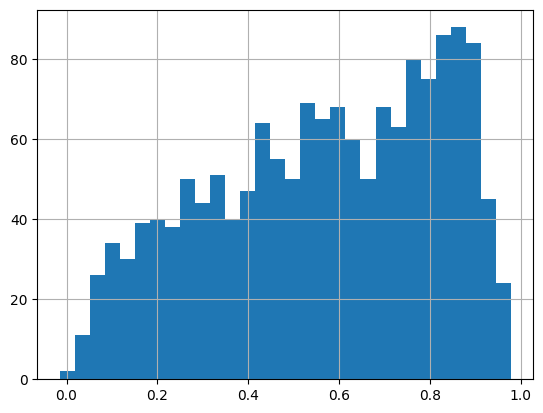

In [ ]:
compare_df = pd.DataFrame({'word':common_idx.keys(), 'cosine_similarity':[s for _,s in sims]})
compare_df.cosine_similarity.hist(bins=30)

In [ ]:
def near_neighbor_sim (embs1, embs2, query, index, k=10):
  idx, iidx = index
  nn1 = near_neighbors (embs1, query, idx, iidx, k=k)
  nn2 = near_neighbors (embs2, query, idx, iidx, k=k)

  common = {w for w, _ in nn1} | {w for w,_ in nn2}
  scores1 = np.array([embs1[idx[w]].dot (embs1[idx[query]]) for w in common])
  scores2 = np.array([embs2[idx[w]].dot (embs2[idx[query]]) for w in common])

  return np.dot (scores1, scores2)/(np.linalg.norm (scores1) * np.linalg.norm (scores2))

In [ ]:
politics_words = [
    'science', 'research', 'medium', 'technology', 'scholar', 'funding', 'datum',
                  #'freedom', 'justice', 'equality', 'democracy', # political abstractions
                 # 'welfare', 'taxes', # partisan political issues
                  #'democrat', 'republican' # political parties
                 ] # from Rodriguez and Spirling 2021


political_words_sims = [(w, near_neighbor_sim (media_aligned_embs, science_aligned_embs, w, (common_idx, common_iidx),k=10)) for w in politics_words]
for w,score in sorted (political_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

research 0.9423981
datum 0.9282909
science 0.90434706
funding 0.8979152
scholar 0.8731411
medium 0.8501884
technology 0.83427846


In [ ]:
query = 'impact'
print (f'Near neighbors for {query} in the MEDIA corpus')
for item in near_neighbors (media_embs, query, media_idx, media_iidx, k=10):
  print (item)
print ()
print (f'Near neighbors for {query} in the SCIENCE corpus')
for item in near_neighbors (science_embs, query, science_idx, science_iidx, k=10):
  print (item)

Near neighbors for impact in the MEDIA corpus
('headwind', 0.84616965)
('accelerate', 0.79679227)
('favorable', 0.7942039)
('improve', 0.78805304)
('improvement', 0.78796726)
('dampen', 0.7839547)
('productivity', 0.7829533)
('robust', 0.78251827)
('rapid', 0.7818416)
('ongoing', 0.77504504)

Near neighbors for impact in the SCIENCE corpus
('occur', 0.99972844)
('remain', 0.99970764)
('strong', 0.9997018)
('allow', 0.99969435)
('involve', 0.99969286)
('production', 0.99968994)
('good', 0.9996899)
('require', 0.99968773)
('great', 0.99968576)
('current', 0.9996829)


In [ ]:
for word in politics_words:
  print(word + ": " + str(media_model.wv.most_similar(word, topn=5)))
for word in politics_words:
  print(word + ": " + str(science_model.wv.most_similar(word, topn=5)))

Top-5 most similar words for media corpus 


science: [('advertising', 0.8942601084709167), ('computer', 0.8904563784599304), ('youtube', 0.8896752595901489), ('tablet', 0.8778342008590698), ('sport', 0.8698909878730774)]
research: [('insight', 0.7443492412567139), ('michael', 0.743779182434082), ('edgar', 0.7418513894081116), ('source', 0.736124575138092), ('llc', 0.7286784052848816)]
medium: [('video', 0.8681516051292419), ('site', 0.853236198425293), ('computer', 0.8493536710739136), ('website', 0.8453684449195862), ('social', 0.8354576230049133)]
technology: [('brand', 0.8534090518951416), ('software', 0.8420594930648804), ('player', 0.8366590142250061), ('integrate', 0.8261273503303528), ('internet', 0.82560133934021)]
scholar: [('punishment', 0.9690659642219543), ('rubio', 0.9574353098869324), ('1979', 0.9540910720825195), ('lament', 0.9537050127983093), ('hungry', 0.9531853795051575)]
funding: [('financing', 0.9146556258201599), ('direct', 0.8789273500442505), ('payday', 0.84489